# Monte Carlo Method

The Monte Carlo method is a computational technique that relies on randomness to approximate complex outcomes. It involves generating random samples or simulations to model and estimate a range of possible results. By performing a large number of simulations, the method provides statistical estimates for quantities of interest, making it particularly useful for problems with multiple variables, uncertainties, or non-analytical solutions. In finance, Monte Carlo simulations are often used for risk assessment, option pricing, and portfolio optimization.

In [45]:
# Define Imports
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd

## Monte Carlo method to price European call options

The `monte_carlo_european_option` is defined to calculate option prices using the **Monte Carlo method**. This function simulates multiple stock price paths based on the **Black-Scholes model**, calculates option payoffs for each path, and computes the option price as the average of these payoffs.

The parameters used are defined below:

- **Current Stock Price (S):** The last available adjusted closing price in the historical data is used.
- **Strike Price (K)**: Set to be at-the-money, which means it's the same as the current stock price.
- **Time to Expiration (T)**: The time until the option's expiration, typically in years.
- **Risk-Free Interest Rate (r)**: The assumed risk-free interest rate, often based on government bond yields.
- **Volatility (sigma)**: Estimated based on the historical data, annualized to reflect stock price fluctuations.


In [46]:
# Function to calculate option prices using Monte Carlo method
def monte_carlo_european_option(S, K, T, r, sigma, option_type, n_simulations):
    dt = T / 252  # Number of trading days in a year (assuming 252)
    n_steps = int(T / dt)
    
    option_prices = []
    
    for _ in range(n_simulations):
        # Generate a single stock price path using the Black-Scholes model
        stock_prices = [S]
        for _ in range(n_steps):
            Z = np.random.normal(0, 1)
            S_t = stock_prices[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
            stock_prices.append(S_t)
        
        # Calculate the option payoff
        if option_type == 'call':
            option_payoff = max(stock_prices[-1] - K, 0)
        elif option_type == 'put':
            option_payoff = max(K - stock_prices[-1], 0)
        else:
            raise ValueError("Invalid option_type. Use 'call' or 'put'.")
        
        option_prices.append(option_payoff * np.exp(-r * T))
    
    return np.mean(option_prices)

In [47]:
# Function to download latest ticker information and the calculated values we need
def download_data_ticker(stock_symbol, start_date, end_date):
    # Download historical data for a stock symbol from Yahoo Finance
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Extract the adjusted closing prices (use 'Adj Close' column)
    stock_prices = stock_data['Adj Close']
    dates = stock_prices.index  # Get the dates from the DataFrame
    
    # Extract the last date from the historical data
    current_date = dates[-1]

    # Print the current date used for the simulation
    print(f"Current Date for Simulation: {current_date}")
    
    return stock_prices, stock_prices.iloc[-1]  # Current stock price (use the last available price)

In [48]:
# Function to download the latest SOFR

def download_sofr(start_date, end_date):

    # Fetch SOFR data
    sofr_data = pdr.data.DataReader('SOFR', 'fred', start_date, end_date)

    # Print the latest SOFR rate
    latest_sofr_rate = sofr_data['SOFR'].iloc[-1]
    print(f"Latest SOFR Rate: {latest_sofr_rate:.4f}%")
    
    return latest_sofr_rate

In [49]:
def plot_single_simulation(stock_symbol, start_date, end_date):
    stock_prices, curret_price = download_data_ticker(stock_symbol, start_date, end_date)
    sofr = download_sofr(start_date, end_date)
    # Input values
    S = curret_price 
    K = S  # Option strike price (set it to be at-the-money)
    T = 0.012  # Time to expiration in years (3 days -> 3/252 = 0.012)
    r = sofr  # Risk-free interest rate (5.3%%)
    trading_days_per_year = 252  # Approximate number of trading days in a year
    sigma = np.std(np.log(stock_prices / stock_prices.shift(1))) * np.sqrt(trading_days_per_year)  # Annualized volatility
    print(f'Sigma: {sigma:2f}')
    option_type = 'call'  # 'call' for a call option, 'put' for a put option
    n_simulations = 10000  # Number of Monte Carlo simulations

    # Calculate option prices for different numbers of simulations
    simulations = [10, 100, 1000, 10000]
    option_prices = [monte_carlo_european_option(S, K, T, r, sigma, option_type, n) for n in simulations]
    option_prices_df = pd.DataFrame({'Option Price': option_prices})
    # Define the output CSV file path
    output_csv_path = "option_prices_single_simulation.csv"
    # Export the DataFrame to a CSV file
    option_prices_df.to_csv(output_csv_path, index=False)

    # Create a price vs. option price chart
    plt.figure(figsize=(10, 6))
    plt.plot(simulations, option_prices, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.title(f'Monte Carlo Option Pricing for {stock_symbol} Call Option, with current Price {curret_price:2f}')
    plt.grid(True)

    # Show the chart
    plt.show()

[*********************100%***********************]  1 of 1 completed
Current Date for Simulation: 2023-10-20 00:00:00
Latest SOFR Rate: 5.3000%
Sigma: 0.139636


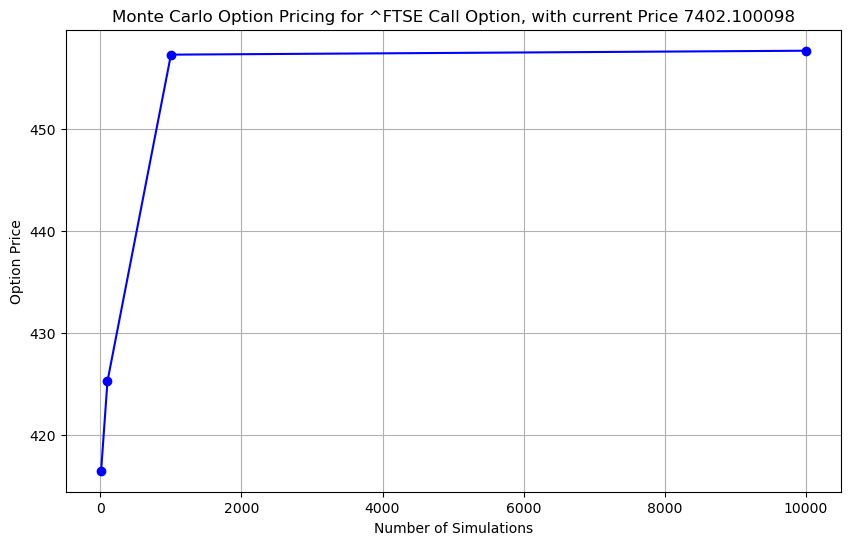

In [50]:
plot_single_simulation('^FTSE', '2021-01-01', '2023-10-21')

## Multiple simulation

The Monte Carlo simulation is run for different numbers of simulations (e.g., 10, 100, 1000, 10000) to observe how the option price estimate converges as the number of simulations increases. For each run, the simulation is repeated 10 times to account for randomness.

In [41]:
def plot_multiple_simulations(stock_symbol, start_date, end_date):
    stock_prices, curret_price = download_data_ticker(stock_symbol, start_date, end_date)
    sofr = download_sofr(start_date, end_date)
    # Input values
    S = curret_price 
    K = S  # Option strike price (set it to be at-the-money)
    T = 0.012  # Time to expiration in years (3 days -> 3/252 = 0.012)
    r = sofr  # Risk-free interest rate (5%)
    trading_days_per_year = 252  # Approximate number of trading days in a year
    sigma = np.std(np.log(stock_prices / stock_prices.shift(1))) * np.sqrt(trading_days_per_year)  # Annualized volatility
    option_type = 'call'  # 'call' for a call option, 'put' for a put option
    n_simulations = 10000  # Number of Monte Carlo simulations

    # List of different numbers of simulations to run
    simulation_counts = [10, 100, 1000, 10000]

    # Run Monte Carlo simulations for each number of simulations
    option_prices_data = []
    for n in simulation_counts:
        option_prices = [monte_carlo_european_option(S, K, T, r, sigma, option_type, n) for _ in range(10)]
        
        option_prices_df = pd.DataFrame({'Option Price': option_prices})
        # Define the output CSV file path
        output_csv_path = f"option_prices_multiple_simulation_{n}.csv"
        # Export the DataFrame to a CSV file
        option_prices_df.to_csv(output_csv_path, index=False)
        
        option_prices_data.append(option_prices)

    # Create a price vs. option price chart with multiple runs
    plt.figure(figsize=(10, 6))
    for i, n in enumerate(simulation_counts):
        plt.plot([i] * 10, option_prices_data[i], marker='o', linestyle='-', label=f'Simulations: {n}')
    plt.xticks(range(len(simulation_counts)), [f'{n}' for n in simulation_counts])
    plt.xlabel('Simulation Run')
    plt.ylabel('Option Price')
    plt.title(f'Monte Carlo Option Pricing for {stock_symbol} Option (Multiple Runs), with current Price {curret_price:2f}')
    plt.legend()
    plt.grid(True)

    # Show the chart
    plt.show()

[*********************100%***********************]  1 of 1 completed
Current Date for Simulation: 2023-10-20 00:00:00
Latest SOFR Rate: 5.3000%


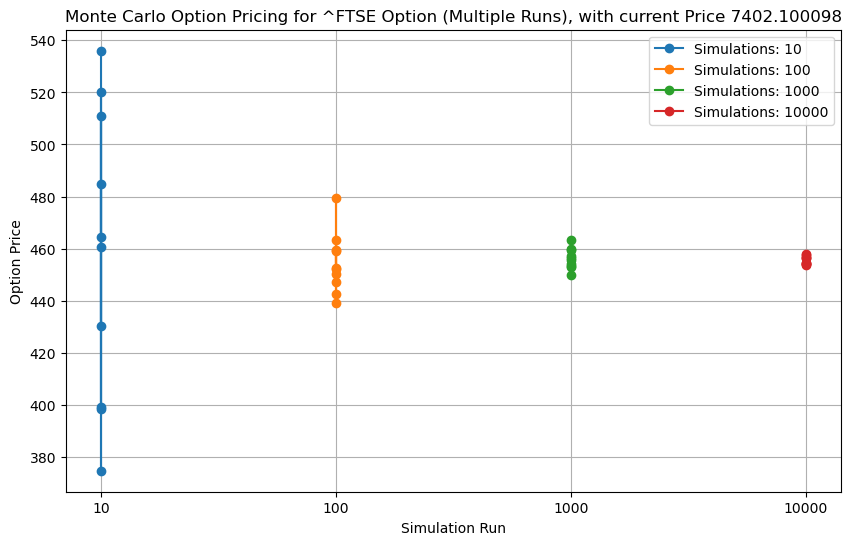

In [42]:
plot_multiple_simulations('^FTSE', '2021-01-01', '2023-10-21')